In [1]:
## Loading package
import os
import torch
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import warnings
# 过滤掉所有警告
warnings.filterwarnings('ignore')

np.random.seed(2024)


# the location of R (used for the mclust clustering)
os.environ['R_HOME'] = 'E:/R-4.3.1'
os.environ['R_USER'] = 'E:/anaconda/lib/site-packages/rpy2'
from sklearn.metrics.cluster import adjusted_rand_score
from utils_ours import mclust_R

file_fold_1 = 'D:/study/learning/spatial_transcriptome/codes/SpatialGlue-main/data/Dataset11_Human_Lymph_Node_A1/adata_RNA'
file_fold_2 = 'D:/study/learning/spatial_transcriptome/codes/SpatialGlue-main/data/Dataset11_Human_Lymph_Node_A1/adata_ADT'

adata_omics_1_1 = sc.read_h5ad(file_fold_1 + '.h5ad')
adata_omics_1_2 = sc.read_h5ad(file_fold_2 + '.h5ad')
Ann_df = pd.read_csv('D:/study/learning/spatial_transcriptome/codes/SpatialGlue-main/data/ours/4_Human_Lymph_Node/annotation.txt', sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata_omics_1_1.obs['Ground Truth'] = Ann_df.loc[adata_omics_1_1.obs_names, 'Ground Truth']
adata_omics_1_2.obs['Ground Truth'] = Ann_df.loc[adata_omics_1_2.obs_names, 'Ground Truth']
adata_omics_1_1.var_names_make_unique()
adata_omics_1_2.var_names_make_unique()

from preprocess import clr_normalize_each_cell


# RNA
sc.pp.filter_genes(adata_omics_1_1, min_cells=10)
sc.pp.highly_variable_genes(adata_omics_1_1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics_1_1, target_sum=1e4)
sc.pp.log1p(adata_omics_1_1)
sc.pp.scale(adata_omics_1_1)

adata_omics_1_1 =  adata_omics_1_1[:, adata_omics_1_1.var['highly_variable']]

# Protein
adata_omics_1_2 = clr_normalize_each_cell(adata_omics_1_2)
sc.pp.scale(adata_omics_1_2)

ground_truth_counts = adata_omics_1_1.obs['Ground Truth'].value_counts()

# 打印结果
print(ground_truth_counts)

colors = [
    '#f9c74f', '#335c67', '#7f4f24', '#e76f51'
]

Ground Truth
medulla cords                  1188
medulla sinuses                 797
cortex                          753
pericapsular adipose tissue     320
capsule                         204
subcapsular sinus                74
follicle                         60
medulla vessels                  57
hilum                            23
trabeculae                        8
Name: count, dtype: int64


In [ ]:
# 定义类别列表
categories = ['medulla cords', 'medulla sinuses', 'cortex', 'pericapsular adipose tissue']

adata_omics_1_1 = adata_omics_1_1[adata_omics_1_1.obs['Ground Truth'].isin(categories)]
adata_omics_1_2 = adata_omics_1_2[adata_omics_1_2.obs['Ground Truth'].isin(categories)]

def random_sample_per_category(adata, categories, sample_size=300):
    # 初始化一个空的AnnData对象，用于存储最终的样本
    sampled_adata = None
    
    # 遍历每个类别
    for category in categories:
        # 筛选出当前类别的样本
        category_idx = adata.obs['Ground Truth'] == category
        
        # 如果当前类别的样本数大于sample_size，则随机选取sample_size个样本
        if category_idx.sum() > sample_size:
            indices = np.random.choice(category_idx[category_idx].index, size=sample_size, replace=False)
        else:
            indices = category_idx[category_idx].index
        
        # 获取当前类别的样本数据
        category_data = adata[indices]
        
        # 如果sampled_adata为空，则直接赋值，否则合并
        if sampled_adata is None:
            sampled_adata = category_data
        else:
            sampled_adata = sampled_adata.concatenate([category_data], join='outer', index_unique='-')
    
    return sampled_adata

adata_omics_1_1 = random_sample_per_category(adata_omics_1_1, categories, 300)
adata_omics_1_2 = random_sample_per_category(adata_omics_1_2, categories, 300)

original_to_new_labels = {
    "medulla cords": 'a',
    "medulla sinuses": 'b',
    "cortex": 'c',
    "pericapsular adipose tissue": 'd'
}

categories_order = [
    'a', 'b', 'c', 'd'
]

adata_omics_1_1.obs['Ground Truth'] = adata_omics_1_1.obs['Ground Truth'].map(original_to_new_labels)
adata_omics_1_2.obs['Ground Truth'] = adata_omics_1_2.obs['Ground Truth'].map(original_to_new_labels)

# 确保更新后的列仍然是分类类型
adata_omics_1_1.obs['Ground Truth'] = pd.Categorical(adata_omics_1_1.obs['Ground Truth'],categories=categories_order, ordered=True)
adata_omics_1_2.obs['Ground Truth'] = pd.Categorical(adata_omics_1_2.obs['Ground Truth'],categories=categories_order, ordered=True)

# # 随机分成3个batch
batch = [1 + (i % 3) for i in range(1200)]
adata_omics_1_1.obs['batch'] = batch
adata_omics_1_2.obs['batch'] = batch

In [ ]:
## spatial 1
# x_values = np.linspace(0, 60, 20, endpoint=False)
# y_values = np.linspace(0, 60, 20, endpoint=False)

# # 初始化坐标数组
# coordinates = np.zeros((20 * 20, 2), dtype=int)

# # 填充坐标数组
# for i in range(20):
#     for j in range(20):
#         coordinates[i * 20 + j, 0] = x_values[j]
#         coordinates[i * 20 + j, 1] = y_values[i]
# coordinates = np.repeat(coordinates, 3, axis=0)


# ## 确定分割点
# x_split = 30
# y_split = 30
# # 创建四个区域的坐标
# quadrant1 = coordinates[(coordinates[:, 0] < x_split) & (coordinates[:, 1] < y_split)]
# quadrant2 = coordinates[(coordinates[:, 0] >= x_split) & (coordinates[:, 1] < y_split)]
# quadrant3 = coordinates[(coordinates[:, 0] < x_split) & (coordinates[:, 1] >= y_split)]
# quadrant4 = coordinates[(coordinates[:, 0] >= x_split) & (coordinates[:, 1] >= y_split)]

# # 合并四个区域的坐标
# all_coordinates = np.vstack((quadrant1, quadrant2, quadrant3, quadrant4))
# adata_omics_1_1.obsm['spatial'] = all_coordinates
# adata_omics_1_2.obsm['spatial'] = all_coordinates


# # spatial 2
# x_values = np.linspace(0, 60, 20, endpoint=False)
# y_values = np.linspace(0, 60, 20, endpoint=False)

# # 初始化坐标数组
# coordinates = np.zeros((20 * 20, 2), dtype=int)

# # 填充坐标数组
# for i in range(20):
#     for j in range(20):
#         coordinates[i * 20 + j, 0] = x_values[j]
#         coordinates[i * 20 + j, 1] = y_values[i]
# coordinates = np.repeat(coordinates, 3, axis=0)
# adata_omics_1_1.obsm['spatial'] = coordinates
# adata_omics_1_2.obsm['spatial'] = coordinates


## spatial 3
# x_values = np.linspace(0, 60, 20, endpoint=False)
# y_values = np.linspace(0, 60, 20, endpoint=False)

# # 初始化坐标数组
# coordinates = np.zeros((20 * 20, 2), dtype=int)

# # 填充坐标数组
# for i in range(20):
#     for j in range(20):
#         coordinates[i * 20 + j, 0] = x_values[j]
#         coordinates[i * 20 + j, 1] = y_values[i]

# # 计算每个点与点（28.5,28.5）之间的距离
# distances = np.sqrt((coordinates[:, 0] - 0) ** 2 + (coordinates[:, 1] - 0) ** 2)

# # 根据距离对坐标数组进行排序
# # argsort()函数返回的是数组值从小到大的索引值
# sorted_indices = np.argsort(distances)
# sorted_coordinates = coordinates[sorted_indices]

# sorted_coordinates = np.repeat(sorted_coordinates, 3, axis=0)

# adata_omics_1_1.obsm['spatial'] = sorted_coordinates
# adata_omics_1_2.obsm['spatial'] = sorted_coordinates


## spatial 4
# x_values = np.linspace(0, 60, 20, endpoint=False)
# y_values = np.linspace(0, 60, 20, endpoint=False)

# # 初始化坐标数组
# coordinates = np.zeros((20 * 20, 2), dtype=int)

# # 填充坐标数组
# for i in range(20):
#     for j in range(20):
#         coordinates[i * 20 + j, 0] = x_values[j]
#         coordinates[i * 20 + j, 1] = y_values[i]

# # 计算每个点与点（28.5,28.5）之间的距离
# distances = np.sqrt((coordinates[:, 0] - 28.5) ** 2 + (coordinates[:, 1] - 28.5) ** 2)

# # 根据距离对坐标数组进行排序
# # argsort()函数返回的是数组值从小到大的索引值
# sorted_indices = np.argsort(distances)
# sorted_coordinates = coordinates[sorted_indices]

# sorted_coordinates = np.repeat(sorted_coordinates, 3, axis=0)

# adata_omics_1_1.obsm['spatial'] = sorted_coordinates
# adata_omics_1_2.obsm['spatial'] = sorted_coordinates

In [77]:
x_values = np.linspace(0, 60, 20, endpoint=False)
y_values = np.linspace(0, 60, 20, endpoint=False)

# 初始化坐标数组
coordinates = np.zeros((20 * 20, 2), dtype=int)

# 填充坐标数组
for i in range(20):
    for j in range(20):
        coordinates[i * 20 + j, 0] = x_values[j]
        coordinates[i * 20 + j, 1] = y_values[i]

# 计算每个点与点（28.5,28.5）之间的距离
distances = np.sqrt((coordinates[:, 0] - 0) ** 2 + (coordinates[:, 1] - 0) ** 2)

# 根据距离对坐标数组进行排序
# argsort()函数返回的是数组值从小到大的索引值
sorted_indices = np.argsort(distances)
sorted_coordinates = coordinates[sorted_indices]

sorted_coordinates = np.repeat(sorted_coordinates, 3, axis=0)

adata_omics_1_1.obsm['spatial'] = sorted_coordinates
adata_omics_1_2.obsm['spatial'] = sorted_coordinates

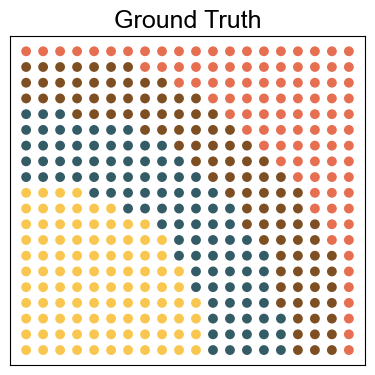

In [78]:
adata_analysis = adata_omics_1_1[adata_omics_1_1.obs['batch']==1].copy()
fig, ax = plt.subplots(1, 1, figsize=(4,4))
plt.rcParams['font.size'] = 15
plt.rcParams['font.sans-serif'] = 'Arial'
sc.pl.embedding(adata_analysis, basis='spatial', color=['Ground Truth'], title=None, s=200, colorbar_loc=None, show=False, ax=ax, palette=colors)
# remove x, y axis
ax.set_xlabel('')
ax.set_ylabel('')
# remove legend
ax.get_legend().remove()
plt.tight_layout()
plt.savefig('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/simulation_scenario_4/annotation4.png')
plt.savefig('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/simulation_scenario_4/annotation4.eps')

In [79]:
adata_omics_1_1.write_h5ad('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/simulation_scenario_4/simulation4_RNA.h5ad')
adata_omics_1_2.write_h5ad('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/simulation_scenario_4/simulation4_Protein.h5ad')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


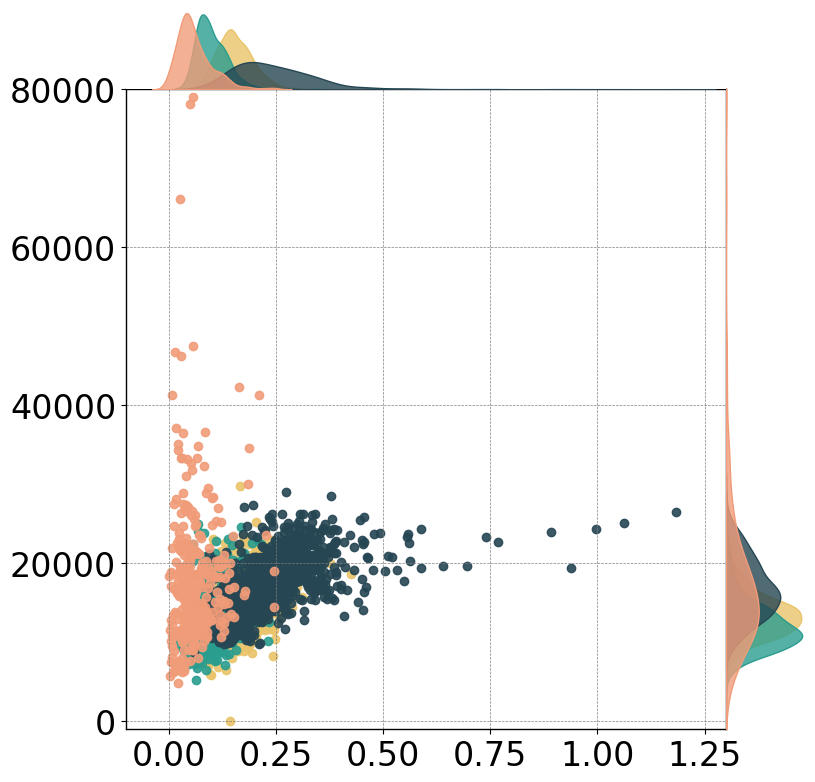

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import warnings
# 过滤掉所有警告
warnings.filterwarnings('ignore')

# 读取数据
file_fold_1 = 'D:/study/learning/spatial_transcriptome/codes/SpatialGlue-main/data/Dataset11_Human_Lymph_Node_A1/adata_RNA'
file_fold_2 = 'D:/study/learning/spatial_transcriptome/codes/SpatialGlue-main/data/Dataset11_Human_Lymph_Node_A1/adata_ADT'

adata_omics_1_1 = sc.read_h5ad(file_fold_1 + '.h5ad')
adata_omics_1_2 = sc.read_h5ad(file_fold_2 + '.h5ad')

# 读取注释文件
Ann_df = pd.read_csv('D:/study/learning/spatial_transcriptome/codes/SpatialGlue-main/data/ours/4_Human_Lymph_Node/annotation.txt', sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata_omics_1_1.obs['Ground Truth'] = Ann_df.loc[adata_omics_1_1.obs_names, 'Ground Truth']
adata_omics_1_2.obs['Ground Truth'] = Ann_df.loc[adata_omics_1_2.obs_names, 'Ground Truth']

# 定义类别列表
categories = ['medulla cords', 'medulla sinuses', 'cortex', 'pericapsular adipose tissue']

# 筛选数据
adata_omics_1_1 = adata_omics_1_1[adata_omics_1_1.obs['Ground Truth'].isin(categories)]
adata_omics_1_2 = adata_omics_1_2[adata_omics_1_2.obs['Ground Truth'].isin(categories)]

# 转换数据格式并计算平均值
RNA = adata_omics_1_1.X.toarray()
protein = adata_omics_1_2.X.toarray()
RNA = np.average(RNA, axis=1)
protein = np.average(protein, axis=1)

# 定义颜色列表
colors = [
    '#e9c46a', '#2a9d8f', '#264653', '#f19c79'
]


fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.15, 0.1, 0.75, 0.8])  # 散点图位置
ax1 = fig.add_axes([0.15, 0.9, 0.75, 0.1])  # 边际分布图位置
ax2 = fig.add_axes([0.9, 0.1, 0.1, 0.8])  # 边际分布图位置

# 散点图
for i, category in enumerate(categories):
    idx = adata_omics_1_1.obs['Ground Truth'] == category
    ax.scatter(RNA[idx], protein[idx], label=category, alpha=0.9, color=colors[i])
ax.set_xlim([-0.1, 1.3])
ax.set_ylim([-1000, 80000])
ticks = np.arange(0, 80001, 20000)  # 从-0.1到80,000，间隔为10,000
ax.set_yticks(ticks)
ax.tick_params(axis='both', labelsize=24)  # 设置坐标轴刻度的字体大小
# 加粗四周边框
for spine in ax.spines.values():
    spine.set_linewidth(1)
    spine.set_color('black')
# 设置网格线
ax.grid(True, linestyle='--', color='gray', linewidth=0.5)

# 边际分布直方图 - RNA
for i, category in enumerate(categories):
    idx = adata_omics_1_1.obs['Ground Truth'] == category
    # ax1.hist(RNA[idx], bins=50, color=colors[i], alpha=1, align='mid', density=True, edgecolor='gray', linewidth=0.5)
    sns.kdeplot(RNA[idx], ax=ax1, vertical=False, color=colors[i], bw_adjust=1, fill=colors[i], alpha=0.8)
# ax1.hist(RNA, bins=100, color='#FECFA7', alpha=1, align='mid', density=True, edgecolor='gray', linewidth=0.5)
ax1.set_ylabel('')
ax1.set_xlim([-0.1, 1.3])
ax1.set_xticks([])
# ax1.set_ylim([-1, 500])
ax1.set_yticks([])
# sns.kdeplot(data=RNA, shade=True, alpha=0.5, ax=ax1, legend=False)
for spine in ax1.spines.values():
        spine.set_visible(False)
# 边际分布直方图 - Protein
for i, category in enumerate(categories):
    idx = adata_omics_1_1.obs['Ground Truth'] == category
    # ax1.hist(RNA[idx], bins=50, color=colors[i], alpha=1, align='mid', density=True, edgecolor='gray', linewidth=0.5)
    sns.kdeplot(protein[idx], ax=ax2, color=colors[i], bw_adjust=1, fill=colors[i], alpha=0.8, vertical=True)
# ax2.hist(protein, bins=100, color='#62C5C8', alpha=1, align='mid', orientation='horizontal', density=True)
# 使用seaborn的kdeplot添加核趋势线
# sns.kdeplot(protein, ax=ax2, vertical=True, color='r', bw_adjust=1)  # vertical=False表示水平方向
ax2.set_xlabel('')
ax2.set_ylim([-0.1, 80000])
ax2.set_xticks([])
ax2.set_yticks([])
for spine in ax2.spines.values():
        spine.set_visible(False)

ax.set_title('')
ax.set_xlabel('', fontsize=28, fontname='Arial')
ax.set_ylabel('', fontsize=28, fontname='Arial')

# 显示图形
plt.tight_layout()
plt.savefig('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/expression.png')
plt.savefig('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/expression.eps')
plt.show()


## Analysis

In [62]:
import pandas as pd
import scanpy as sc
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
import os
os.environ['R_HOME'] = 'E:/R-4.3.1'
os.environ['R_USER'] = 'E:/anaconda/lib/site-packages/rpy2'
from utils_ours import mclust_R
import matplotlib.pyplot as plt
import warnings
# 过滤掉所有警告
warnings.filterwarnings('ignore')

file_fold_1 = 'D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/simulation_scenario_2/simulation2_RNA'
file_fold_2 = 'D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/simulation_scenario_2/simulation2_Protein'

adata_omics_1 = sc.read_h5ad(file_fold_1 + '.h5ad')
adata_omics_2 = sc.read_h5ad(file_fold_2 + '.h5ad')
batch = 1
adata_analysis_1 = adata_omics_1[adata_omics_1.obs['batch'] == batch]
adata_analysis_2 = adata_omics_2[adata_omics_2.obs['batch'] == batch]

sc.tl.pca(adata_analysis_1)
sc.tl.pca(adata_analysis_2)

In [63]:
n = 4
mclust_R(adata_analysis_1, used_obsm='X_pca', num_cluster=n)
obs_df = adata_analysis_1.obs.dropna()
ARI = adjusted_rand_score(obs_df['clusters_mclust'], obs_df['Ground Truth'])
print(ARI)

mclust_R(adata_analysis_2, used_obsm='X_pca', num_cluster=n)
obs_df = adata_analysis_2.obs.dropna()
ARI = adjusted_rand_score(obs_df['clusters_mclust'], obs_df['Ground Truth'])
print(ARI)

fitting ...
  |======================================================================| 100%
0.2270450751252087
fitting ...
  |======================================================================| 100%
0.18053862227040654


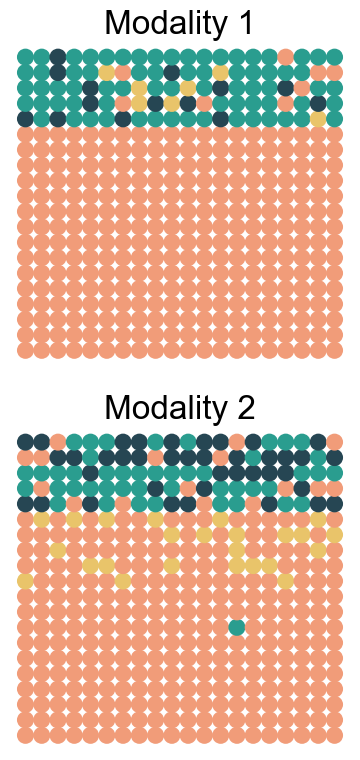

In [64]:
# 定义颜色
colors = [
    '#f19c79', '#2a9d8f', '#264653', '#e9c46a'
]

# 创建一个2x1的子图布局
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 8))  # 修正了figsize参数

# 设置字体大小和字体类型
plt.rcParams['font.size'] = 20
plt.rcParams['font.sans-serif'] = ['Arial']  # 确保字体列表格式正确

# 绘制第一个数据集的嵌入图
sc.pl.embedding(adata_analysis_1, basis='spatial', color=['clusters_mclust'], title=None, s=600, colorbar_loc=None, show=False, ax=ax1, palette=colors, legend_loc=None)
ax1.set_title("Modality 1")
ax1.set_xlabel('')
ax1.set_ylabel('')
for spine in ax1.spines.values():
    spine.set_visible(False)
# 绘制第二个数据集的嵌入图
sc.pl.embedding(adata_analysis_2, basis='spatial', color=['clusters_mclust'], title=None, s=600, colorbar_loc=None, show=False, ax=ax2, palette=colors, legend_loc=None)
ax2.set_title("Modality 2")
ax2.set_xlabel('')
ax2.set_ylabel('')
for spine in ax2.spines.values():
    spine.set_visible(False)

# 调整子图参数，减少四周空白区域
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.tight_layout()
plt.savefig('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/simulation_scenario_2/single_modality.png')
plt.savefig('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/simulation_scenario_2/single_modality.eps')
plt.show()

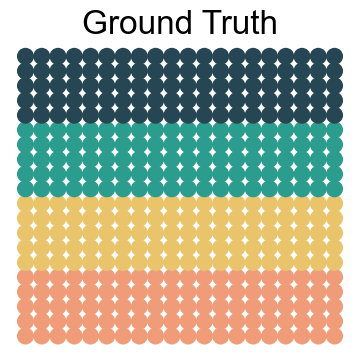

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))  # 修正了figsize参数

# 设置字体大小和字体类型
plt.rcParams['font.size'] = 20
plt.rcParams['font.sans-serif'] = ['Arial']  # 确保字体列表格式正确
colors = [
    '#f19c79', '#e9c46a', '#2a9d8f', '#264653'
]
# 绘制第一个数据集的嵌入图
sc.pl.embedding(adata_analysis_1, basis='spatial', color=['Ground Truth'], title=None, s=600, colorbar_loc=None, show=False, ax=ax, palette=colors, legend_loc=None)
ax.set_title("Ground Truth")
ax.set_xlabel('')
ax.set_ylabel('')
# 显示图表
for spine in ax.spines.values():
    spine.set_visible(False)

# 调整子图参数，减少四周空白区域
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.tight_layout()
plt.savefig('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/simulation_scenario_2/Ground Truth.png')
plt.savefig('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/simulation_scenario_2/Ground Truth.eps')
plt.show()

In [72]:
## 计算核矩阵K
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import eigs
from scipy.stats import zscore

## 带宽选择
def bandwidth_select(expr, method="SJ"):
    if method == "SJ":
        beta = np.median([np.median(np.abs(expr[i, :] - expr[i, :].mean())) for i in range(expr.shape[0])])
    elif method == "Silverman":
        beta = np.median([np.std(expr[i, :]) * len(expr[i, :])**(-1/5) for i in range(expr.shape[0])])
    print(f'bandwidth={beta}')
    return beta

## 核函数计算
def kernel_build(kerneltype, location, bandwidth):
    if kerneltype == "gaussian":
        K = np.exp(-squareform(pdist(location))**2 / bandwidth)
    elif kerneltype == "cauchy":
        K = 1 / (1 + squareform(pdist(location))**2 / bandwidth)
    elif kerneltype == "quadratic":
        ED2 = squareform(pdist(location))**2
        K = 1 - ED2 / (ED2 + bandwidth)
    return K

def kernel_build_sparse(kerneltype, location, bandwidth, tol, ncores=1):
    K = kernel_build(kerneltype, location, bandwidth)
    K_sparse = lil_matrix(K)
    for i in range(K_sparse.shape[0]):
        indices_to_keep = np.abs(K_sparse.data[K_sparse.indptr[i]:K_sparse.indptr[i+1]]) > tol
        K_sparse.data[K_sparse.indptr[i]:K_sparse.indptr[i+1]][indices_to_keep] = 0
    return K_sparse

def spatial_pca_build_kernel(location, kerneltype="gaussian", bandwidthtype="SJ", bandwidth_set_by_user=None, sparse_kernel=False, sparse_kernel_tol=1e-20, sparse_kernel_ncore=1):
    # Normalize location data
    location_normalized = zscore(location)
    
    # Select bandwidth
    if bandwidth_set_by_user is not None:
        bandwidth = bandwidth_set_by_user
    else:
        bandwidth = bandwidth_select(location_normalized, method=bandwidthtype)
    
    # Build kernel matrix
    if not sparse_kernel:
        K = kernel_build(kerneltype, location_normalized, bandwidth)
    else:
        K = kernel_build_sparse(kerneltype, location_normalized, bandwidth, sparse_kernel_tol, sparse_kernel_ncore)
    
    return K

In [154]:
import pandas as pd
import scanpy as sc
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
import os
os.environ['R_HOME'] = 'E:/R-4.3.1'
os.environ['R_USER'] = 'E:/anaconda/lib/site-packages/rpy2'
from utils_ours import mclust_R
import matplotlib.pyplot as plt
import warnings
# 过滤掉所有警告
warnings.filterwarnings('ignore')


file_fold_1 = 'D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/simulation_scenario_1/simulation1_RNA'
file_fold_2 = 'D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/simulation_scenario_1/simulation1_Protein'

adata_omics_1_1 = sc.read_h5ad(file_fold_1 + '.h5ad')
adata_omics_1_2 = sc.read_h5ad(file_fold_2 + '.h5ad')
batch = 1
adata_omics_1_1 = adata_omics_1_1[adata_omics_1_1.obs['batch'] == batch]
adata_omics_1_2 = adata_omics_1_2[adata_omics_1_2.obs['batch'] == batch]

sc.tl.pca(adata_omics_1_1)
sc.tl.pca(adata_omics_1_2)

In [158]:
# bandwidth=0.02, n_DCCA = 10, epochs = 300
from preprocess import fix_seed
fix_seed(2024)

# Define parameters and layers for deep model
from dcca import DCCA
K = spatial_pca_build_kernel(adata_omics_1_1.obsm['spatial'], kerneltype="gaussian", bandwidth_set_by_user=0.028, bandwidthtype="SJ")
K_centered = K - np.mean(K, axis=0) - np.mean(K, axis=1) + np.mean(K)
n_DCCA = 10

features1 = adata_omics_1_1.obsm['X_pca'].shape[1]  # Feature sizes
features2 = adata_omics_1_2.obsm['X_pca'].shape[1]
layers1 = [256, 256, n_DCCA]  # nodes in each hidden layer and the output size
layers2 = [256, 256, n_DCCA]
X = adata_omics_1_1.obsm['X_pca']
Y = adata_omics_1_2.obsm['X_pca']
X = np.dot(K_centered, X)
Y = np.dot(K_centered, Y)

use_rep = ['DCCA_X', "DCCA_Y", "DCCA"]

epochs = 300
dcca = DCCA(input_size1=features1, input_size2=features2, n_components=n_DCCA, layer_sizes1=layers1, layer_sizes2=layers2, epoch_num=epochs, learning_rate=0.001)
dcca.fit([X, Y])
Xs_transformed = dcca.transform([X, Y])
adata_omics_1_1.obsm["DCCA_X"] =  Xs_transformed[0]
adata_omics_1_2.obsm["DCCA_Y"] =  Xs_transformed[1]
adata_omics_1_1.obsm["DCCA"] = np.concatenate((adata_omics_1_1.obsm["DCCA_X"], adata_omics_1_2.obsm["DCCA_Y"]),axis=1)

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 300/300 [00:07<00:00, 37.51it/s]

model training finished !


In [159]:
use_rep = ['DCCA_X','DCCA_Y', 'DCCA']
n = 4
mclust_R(adata_omics_1_1, used_obsm=use_rep[0], num_cluster=n)
obs_df = adata_omics_1_1.obs.dropna()
ARI_1 = adjusted_rand_score(obs_df['clusters_mclust'], obs_df['Ground Truth'])
print(f'n={n}, DCCA_X, ARI = {ARI_1}')
    
mclust_R(adata_omics_1_2, used_obsm=use_rep[1], num_cluster=n)
obs_df = adata_omics_1_1.obs.dropna()
ARI_2 = adjusted_rand_score(obs_df['clusters_mclust'], obs_df['Ground Truth'])
print(f'n={n}, DCCA_Y, ARI = {ARI_2}')

# mclust_R(adata_omics_1_1, used_obsm=use_rep[2], num_cluster=n)
# obs_df = adata_omics_1_1.obs.dropna()
# ARI_3 = adjusted_rand_score(obs_df['clusters_mclust'], obs_df['Ground Truth'])
# print(f'n={n}, DCCA, ARI = {ARI_3}')

fitting ...
  |======================================================================| 100%
n=4, DCCA_X, ARI = 0.885876128536345
fitting ...
  |======================================================================| 100%
n=4, DCCA_Y, ARI = 0.885876128536345


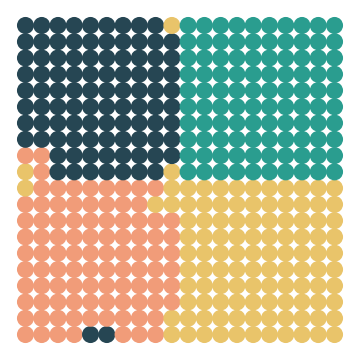

In [157]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))  # 修正了figsize参数
colors = [
    '#f19c79', '#e9c46a', '#2a9d8f', '#264653'
]


# 设置字体大小和字体类型
plt.rcParams['font.size'] = 20
plt.rcParams['font.sans-serif'] = ['Arial']  # 确保字体列表格式正确

# 绘制第一个数据集的嵌入图
sc.pl.embedding(adata_omics_1_1, basis='spatial', color=['clusters_mclust'], title=None, s=600, colorbar_loc=None, show=False, ax=ax, palette=colors, legend_loc=None)
ax.set_title("")
ax.set_xlabel('')
ax.set_ylabel('')
# 显示图表

for spine in ax.spines.values():
    spine.set_visible(False)

# 调整子图参数，减少四周空白区域
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.tight_layout()

In [69]:
# 假设adata_omics_1_1.obs['Ground Truth']是你的DataFrame列
# # 获取现有的类别
# categories = adata_omics_1_1.obs['Ground Truth'].cat.categories

# # 添加新的类别'e'
# categories = np.append(categories, 'e')
# adata_omics_1_1.obs['Ground Truth'] = adata_omics_1_1.obs['Ground Truth'].cat.set_categories(categories)

# 随机选择20个点的索引
random_indices = np.random.choice(adata_omics_1_1.obs['Ground Truth'].index, size=100, replace=False)

# 将这些点的类别更改为'e'
adata_omics_1_1.obs.loc[random_indices, 'Ground Truth'] = 'e'

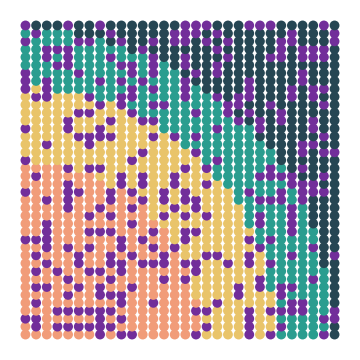

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))  # 修正了figsize参数
colors = [
    '#f19c79', '#e9c46a', '#2a9d8f', '#264653', '#722E9A'
]
# colors = [
#     '#d4e09b', '#f6f4d2', '#cbdfbd', '#f19c79', '#722E9A'
# ]

# 设置字体大小和字体类型
plt.rcParams['font.size'] = 20
plt.rcParams['font.sans-serif'] = ['Arial']  # 确保字体列表格式正确

# 绘制第一个数据集的嵌入图
sc.pl.embedding(adata_omics_1_1, basis='spatial', color=['Ground Truth'], title=None, s=200, colorbar_loc=None, show=False, ax=ax, palette=colors, legend_loc=None)
ax.set_title("")
ax.set_xlabel('')
ax.set_ylabel('')
# 显示图表

for spine in ax.spines.values():
    spine.set_visible(False)

# 调整子图参数，减少四周空白区域
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

plt.tight_layout()